In [1]:
import numpy as np
import pandas
import pm4py
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
import scipy.stats as stats
import ot
import os
from tqdm import tqdm
import collections
import matplotlib.dates as md

import sys
sys.path.append('../../TaskExecutionTimeMining/')
from drbart_parser import *
from event_log_transformer import *

sys.path.append('../../Evaluation/')
from process_evaluation import *

In [2]:
file_path = '../../../data/BPI Challenge 2017.xes'
event_log = pm4py.read_xes(file_path)

parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

In [3]:
event_log = TransformEventLog.seconds_in_day(event_log)

In [5]:
sample_schedule_start_time(1000, 'User_109', 'W_Handle leads', {}, {})

4.879894970831216e-07

In [6]:
sample_start_complete_time(1000, 'User_109', 'W_Handle leads', {}, {})

8.100532091465912

In [7]:
#sample_suspend_resume_time(1000, 'User_109', 'W_Handle leads', {}, {})
sample_suspend_resume_time(1000, 'User_109', 'W_Handle leads', 5)

97899.04196828682

In [8]:
event_log

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,seconds_in_day
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35475
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35475
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35475
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35556
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202262,Deleted,User_1,W_Call after offers,Workflow,Workitem_1817549786,ate_abort,2017-01-06 06:33:02.212000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23582
1202263,Created,User_1,W_Call after offers,Workflow,Workitem_363876066,schedule,2017-01-06 06:33:02.221000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23582
1202264,statechange,User_28,A_Cancelled,Application,ApplState_1869071797,complete,2017-01-16 09:51:21.114000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35481
1202265,statechange,User_28,O_Cancelled,Offer,OfferState_420066181,complete,2017-01-16 09:51:21.139000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_1580299144,35481


In [4]:
import importlib
importlib.reload(sys.modules['process_evaluation'])
from process_evaluation import *

drbart_start_suspend = DRBART(parser_dir = '../../../models/bpic_2017_start_suspend/concept-name_resource_seconds-in-day_day-of-week/')
drbart_suspend_resume = DRBART(parser_dir = '../../../models/bpic_2017_suspend_resume/concept-name_resource_seconds-in-day_day-of-week/')
sample_drbart_bpic2017 = SampleOutcomes_DRBART_BPIC2017_R_A_S_D(event_log, drbart_start_suspend, drbart_suspend_resume)

In [5]:
case_name = 'Application_652823628'
r = [sample_drbart_bpic2017.sample_case(case_name) for i in range(1000)]

KeyboardInterrupt: 

In [10]:
event_log['new_concept'] = event_log['concept:name'] +  '__' + event_log['EventID'] + '__' + event_log['lifecycle:transition']
event_log = event_log[event_log['concept:name'].str.startswith('W_')]
case_log = event_log[event_log['case:concept:name'] == case_name]
net, im, fm = pm4py.discover_petri_net_inductive(case_log,
                                                activity_key='new_concept',
                                                case_id_key='case:concept:name',
                                                timestamp_key='time:timestamp')
dg = pm4py.visualization.petri_net.visualizer.apply(net)
pm4py.visualization.petri_net.visualizer.matplotlib_view(dg)

In [12]:
pm4py.visualization.petri_net.visualizer.save(dg, 'process_instance.png')

''

In [85]:
np.mean(nr) / 3600 / 24 / 10**9

1.682625588235529e-05

In [82]:
nr = np.array(r)
print('mean', datetime.datetime.fromtimestamp(np.mean(nr)))
print('median', datetime.datetime.fromtimestamp(np.median(nr)))
#print('variance', datetime.datetime.fromtimestamp(np.var(nr)))
print('min', datetime.datetime.fromtimestamp(np.min(nr)))
print('max', datetime.datetime.fromtimestamp(np.max(nr)))
#print(nr)
print(datetime.datetime.fromtimestamp(sample_end_time(case_name)[0]))
print(datetime.datetime.fromtimestamp(sample_end_time(case_name)[2]))

mean 2016-01-26 07:08:28.235497
median 2016-01-21 21:53:57.309709
min 2016-01-04 08:59:18.270525
max 2016-03-26 17:50:29.961702


NameError: name 'sample_end_time' is not defined

In [ ]:
plt.hist(nr, bins=100)
plt.axvline(x=sample_end_time(case_name)[2], color='red')

/tmp/ipykernel_33874/2311270614.py:39: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.hist(case_samples, bins=pandas.date_range(start= pandas.to_datetime(min(case_samples)).floor('D'), end=pandas.to_datetime(max(case_samples)).ceil('D'), freq='6H'), density=True)


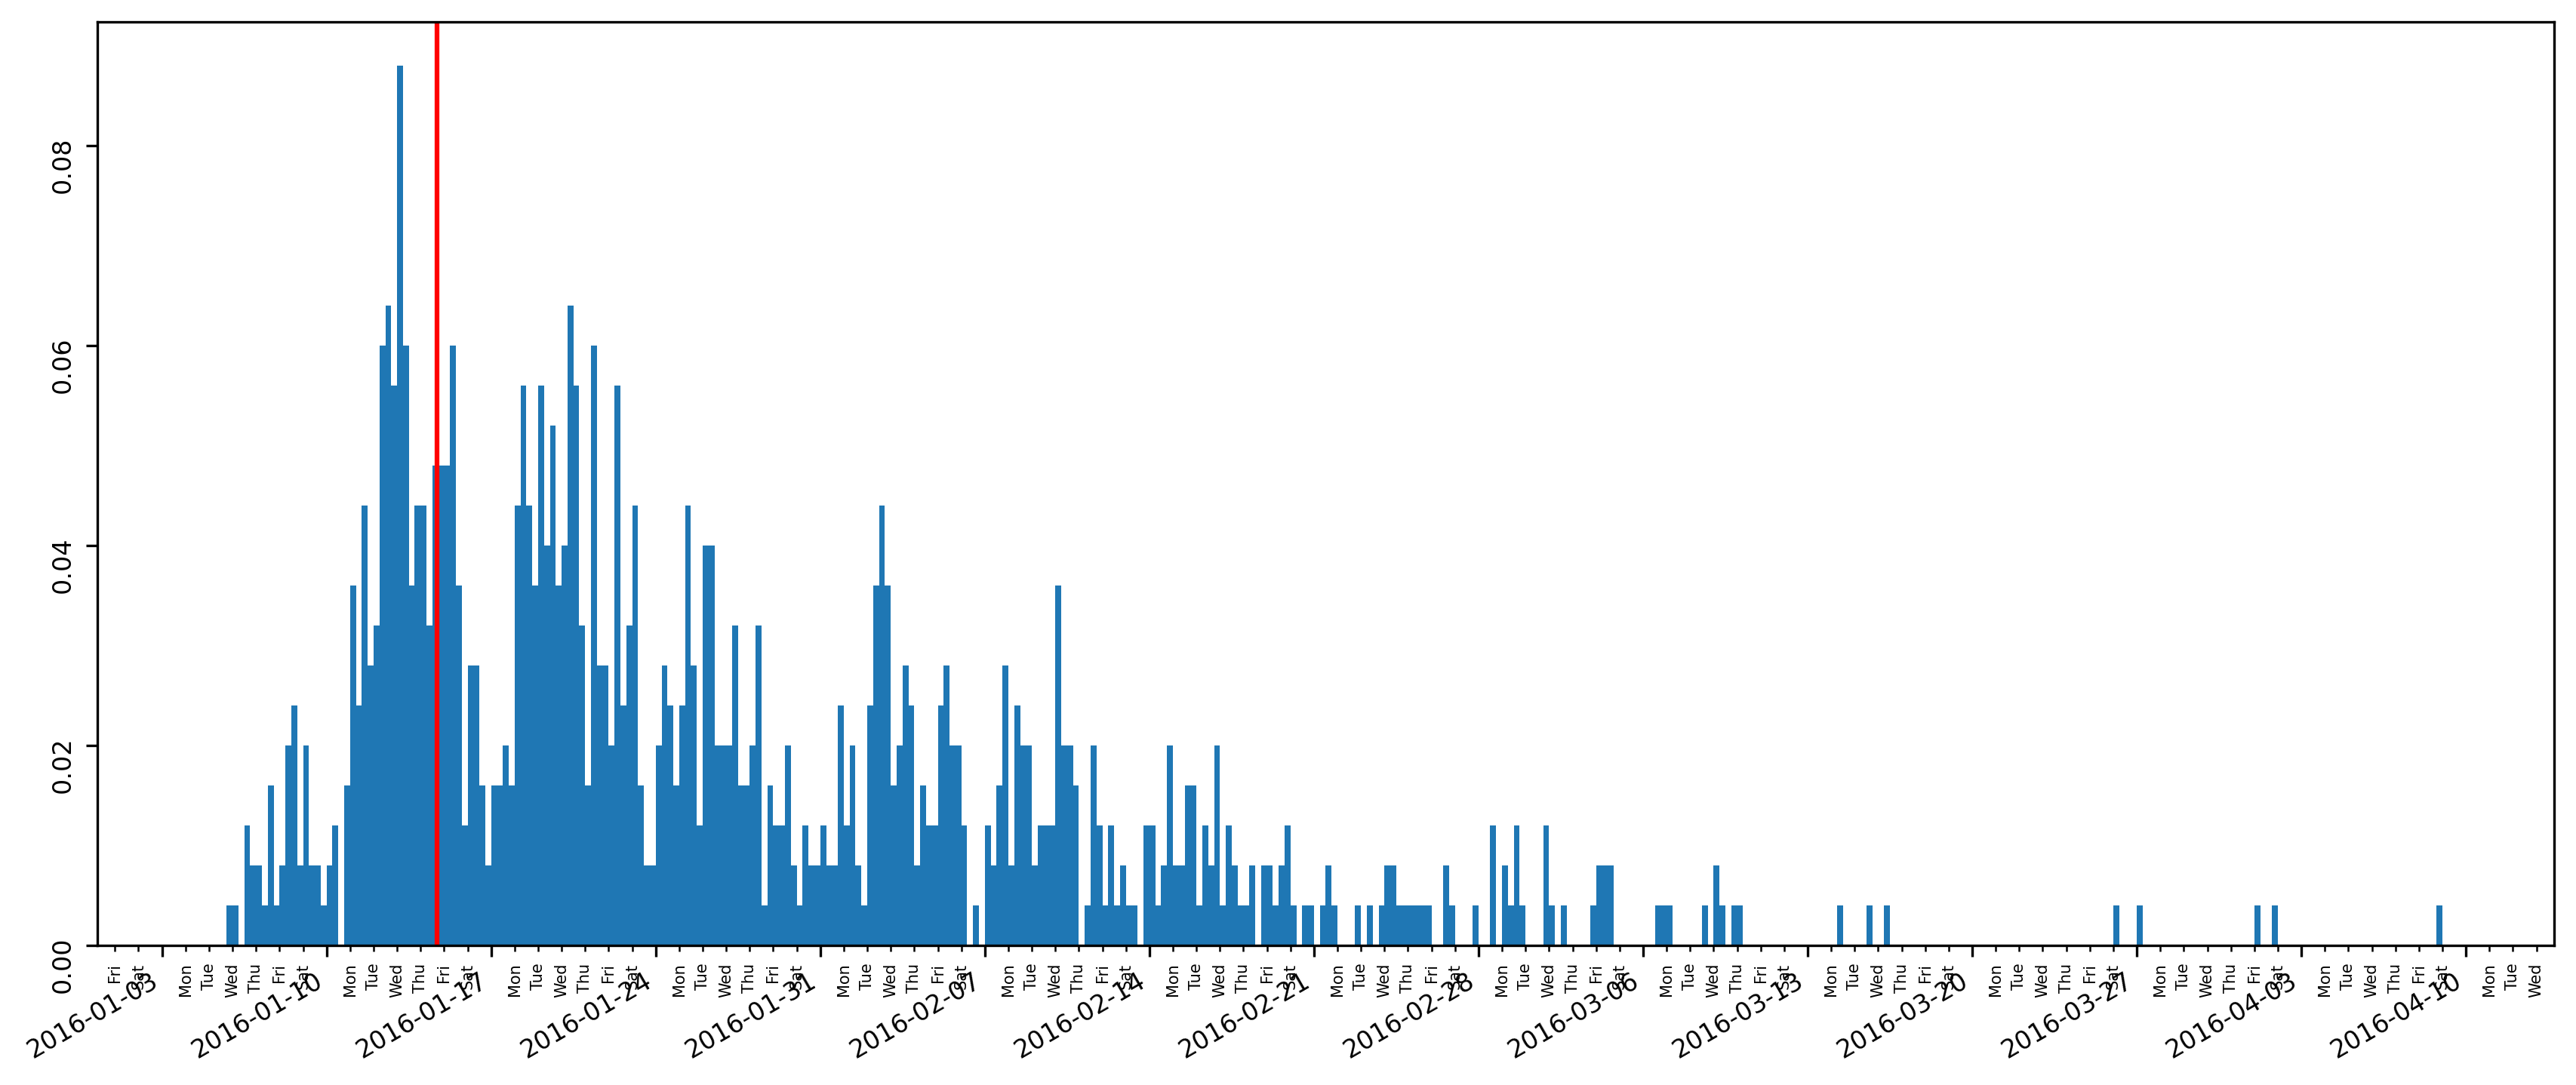

Application_652823628 [0.03467698] 0.0 2016-01-05 20:45:17.602094 2016-04-08 21:42:13.386012 94 days, 0:56:55.783918


/tmp/ipykernel_33874/2311270614.py:39: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.hist(case_samples, bins=pandas.date_range(start= pandas.to_datetime(min(case_samples)).floor('D'), end=pandas.to_datetime(max(case_samples)).ceil('D'), freq='6H'), density=True)


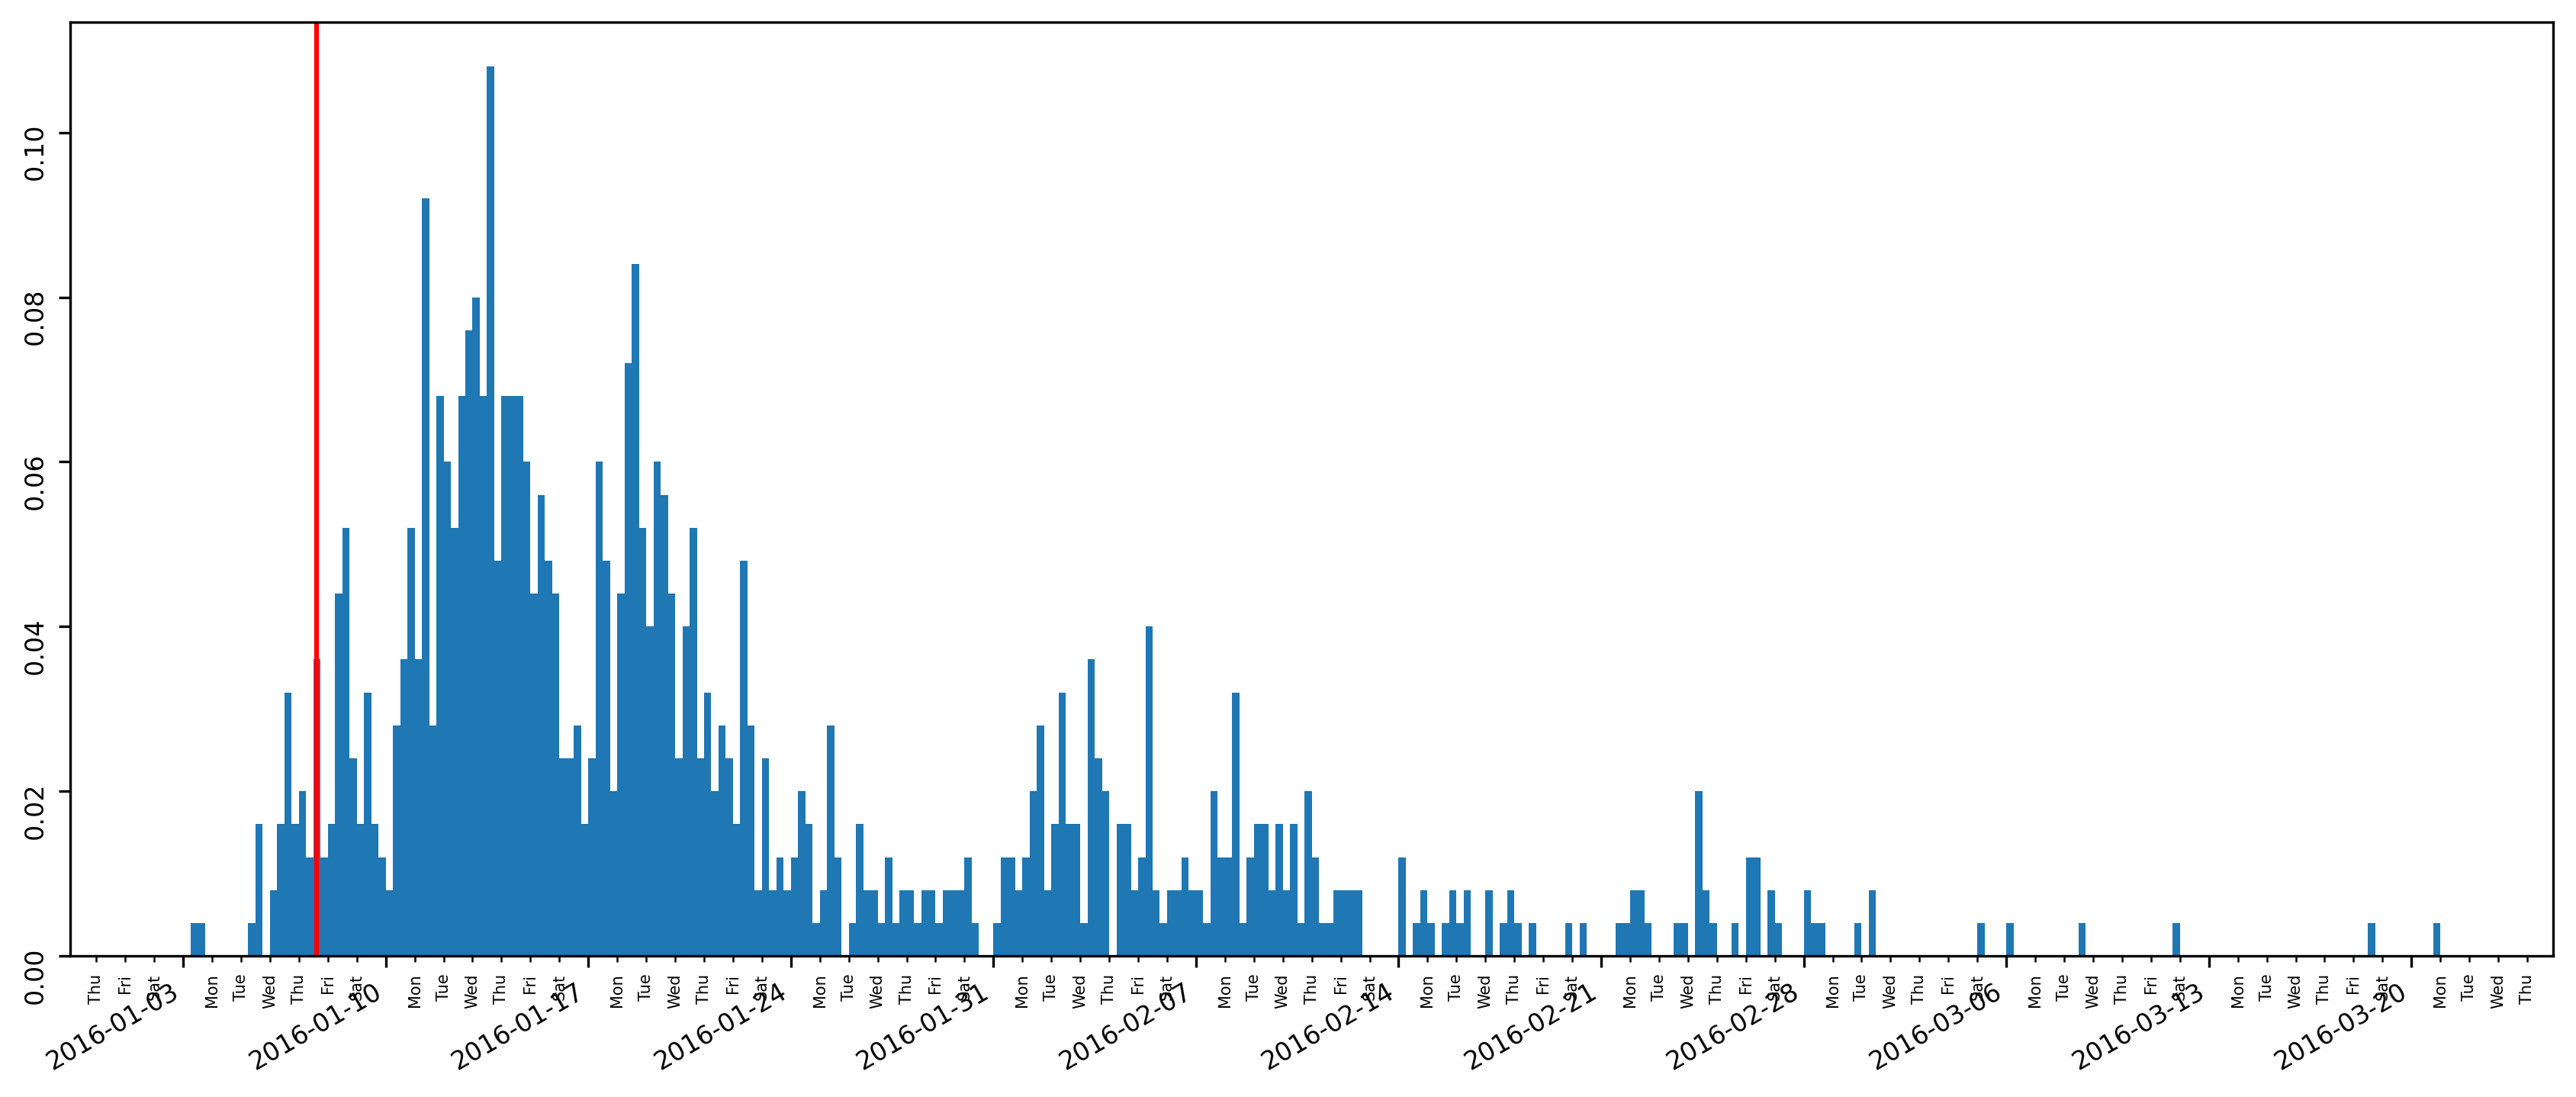

Application_1691306052 [0.02250962] 0.0 2016-01-03 11:01:32.899827 2016-03-20 21:16:16.050528 77 days, 10:14:43.150701


/tmp/ipykernel_33874/2311270614.py:39: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.hist(case_samples, bins=pandas.date_range(start= pandas.to_datetime(min(case_samples)).floor('D'), end=pandas.to_datetime(max(case_samples)).ceil('D'), freq='6H'), density=True)


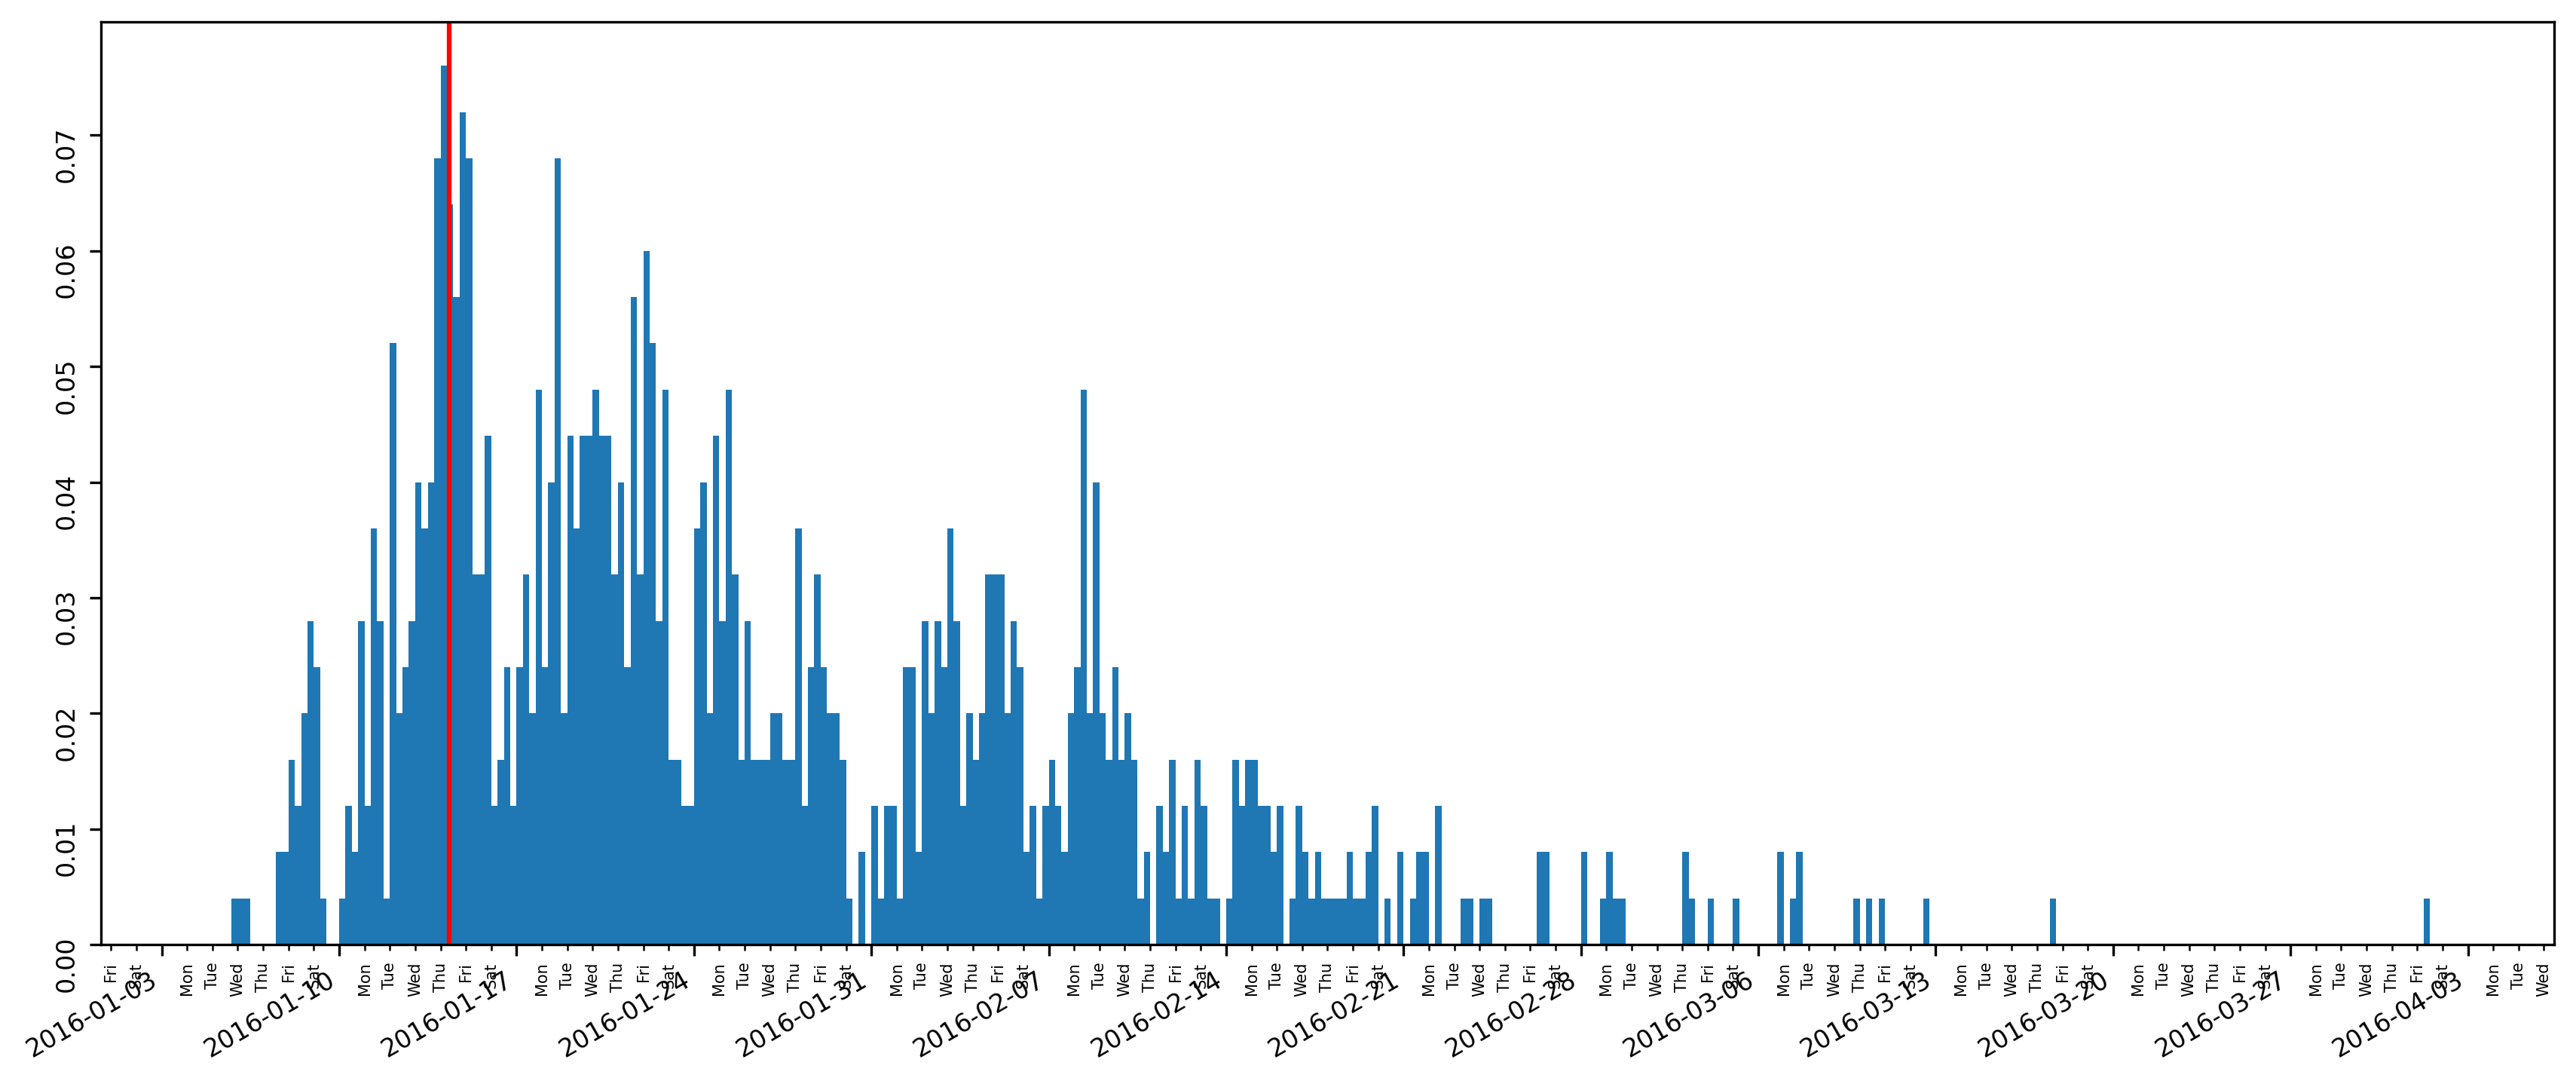

Application_428409768 [0.03432625] 0.0 2016-01-05 18:17:31.428805 2016-04-01 07:09:47.031708 86 days, 12:52:15.602903


/tmp/ipykernel_33874/2311270614.py:39: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.hist(case_samples, bins=pandas.date_range(start= pandas.to_datetime(min(case_samples)).floor('D'), end=pandas.to_datetime(max(case_samples)).ceil('D'), freq='6H'), density=True)


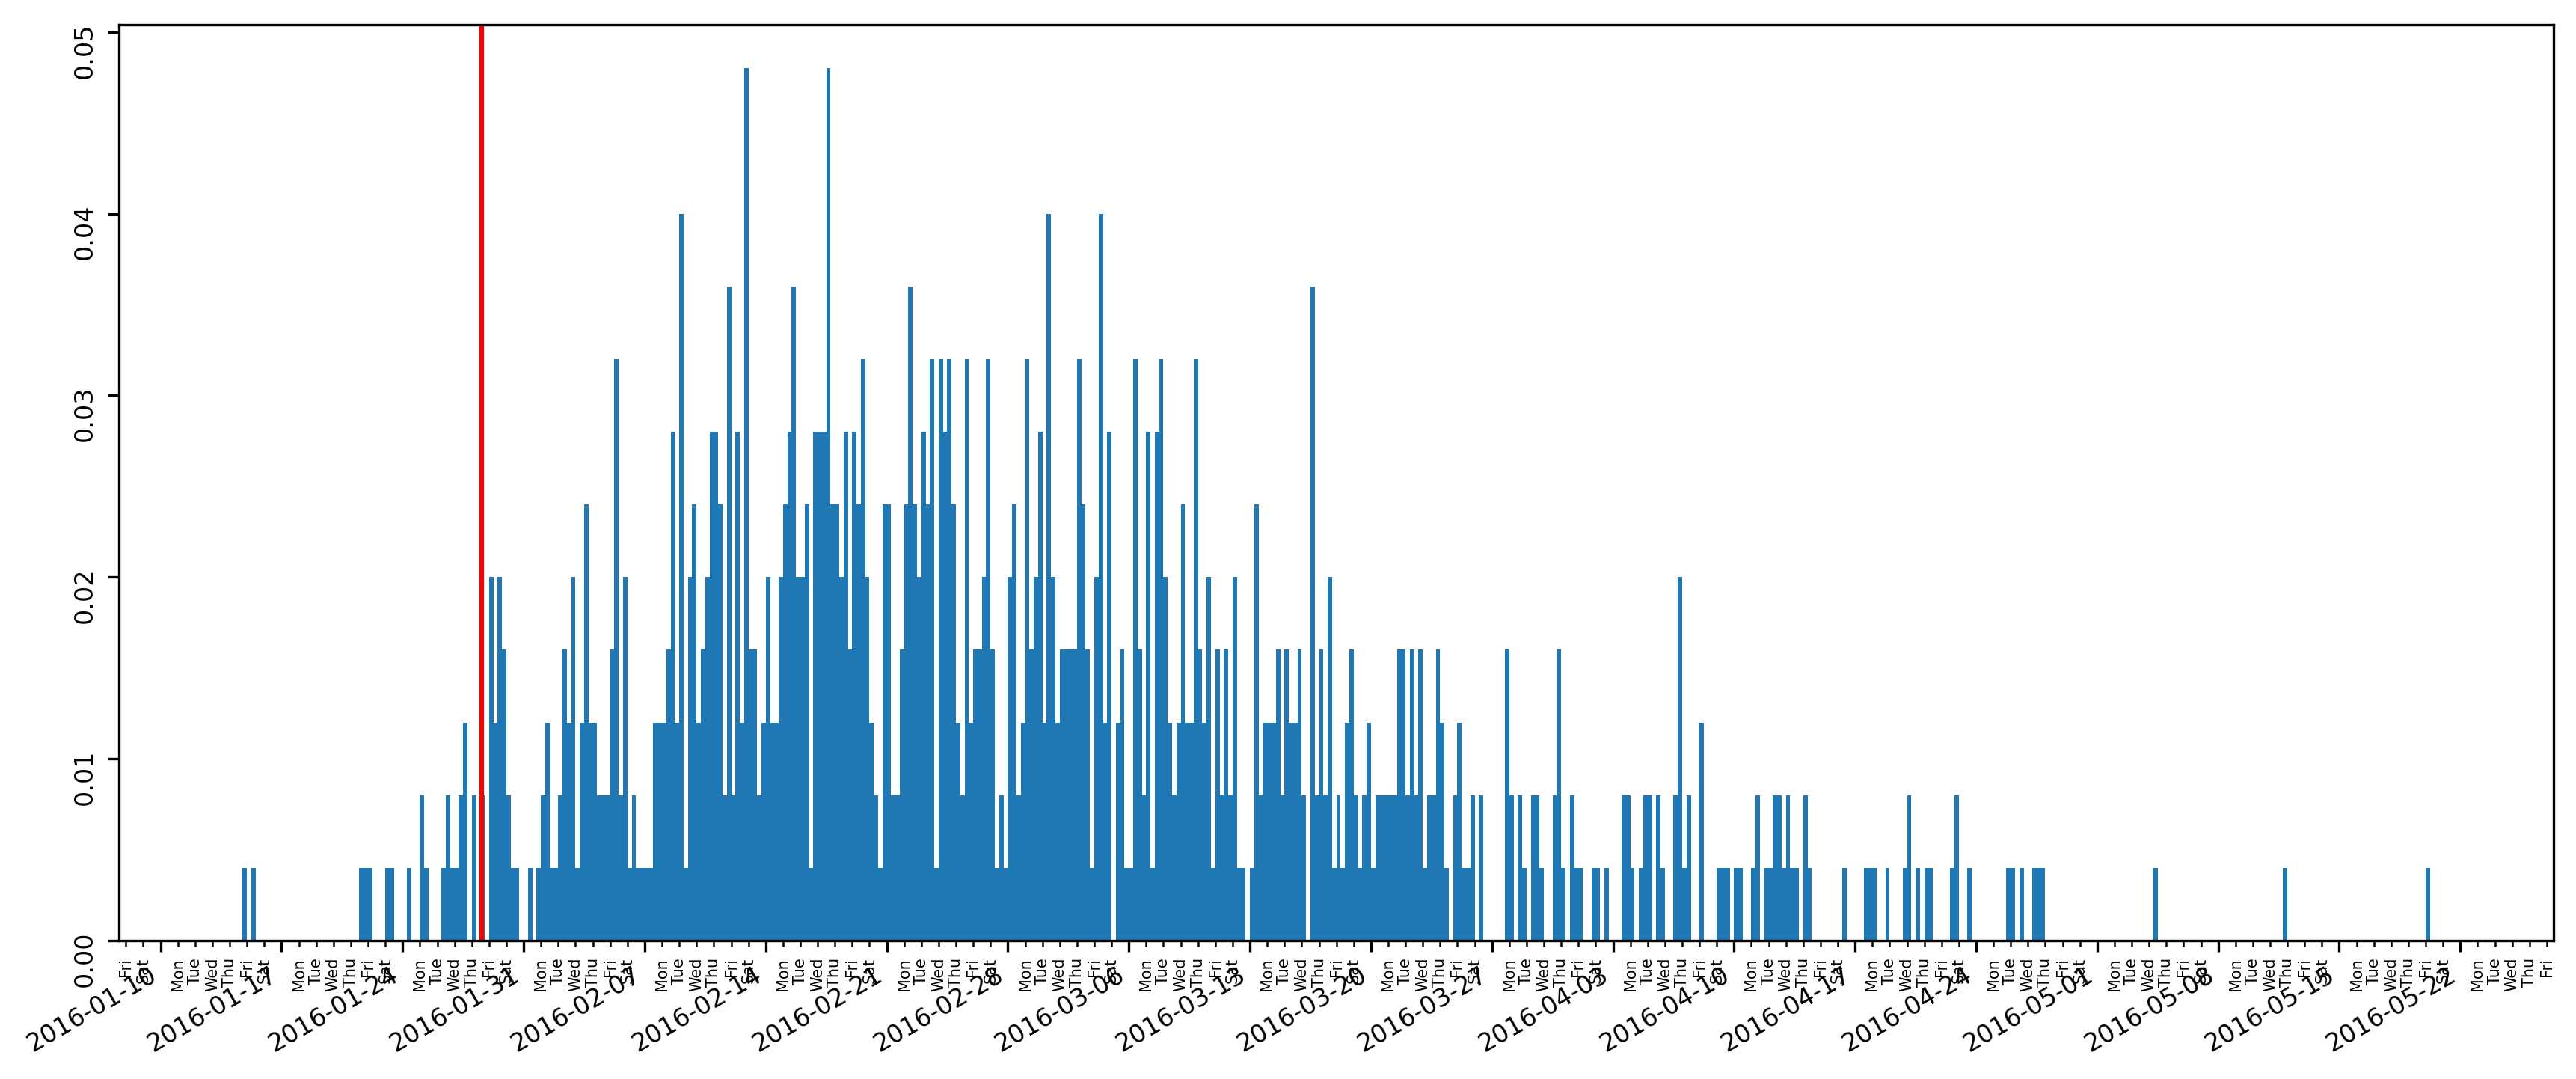

Application_1746793196 [0.00611343] 0.0 2016-01-14 21:07:09.587364 2016-05-20 01:53:39.891546 126 days, 4:46:30.304182


/tmp/ipykernel_33874/2311270614.py:39: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.hist(case_samples, bins=pandas.date_range(start= pandas.to_datetime(min(case_samples)).floor('D'), end=pandas.to_datetime(max(case_samples)).ceil('D'), freq='6H'), density=True)


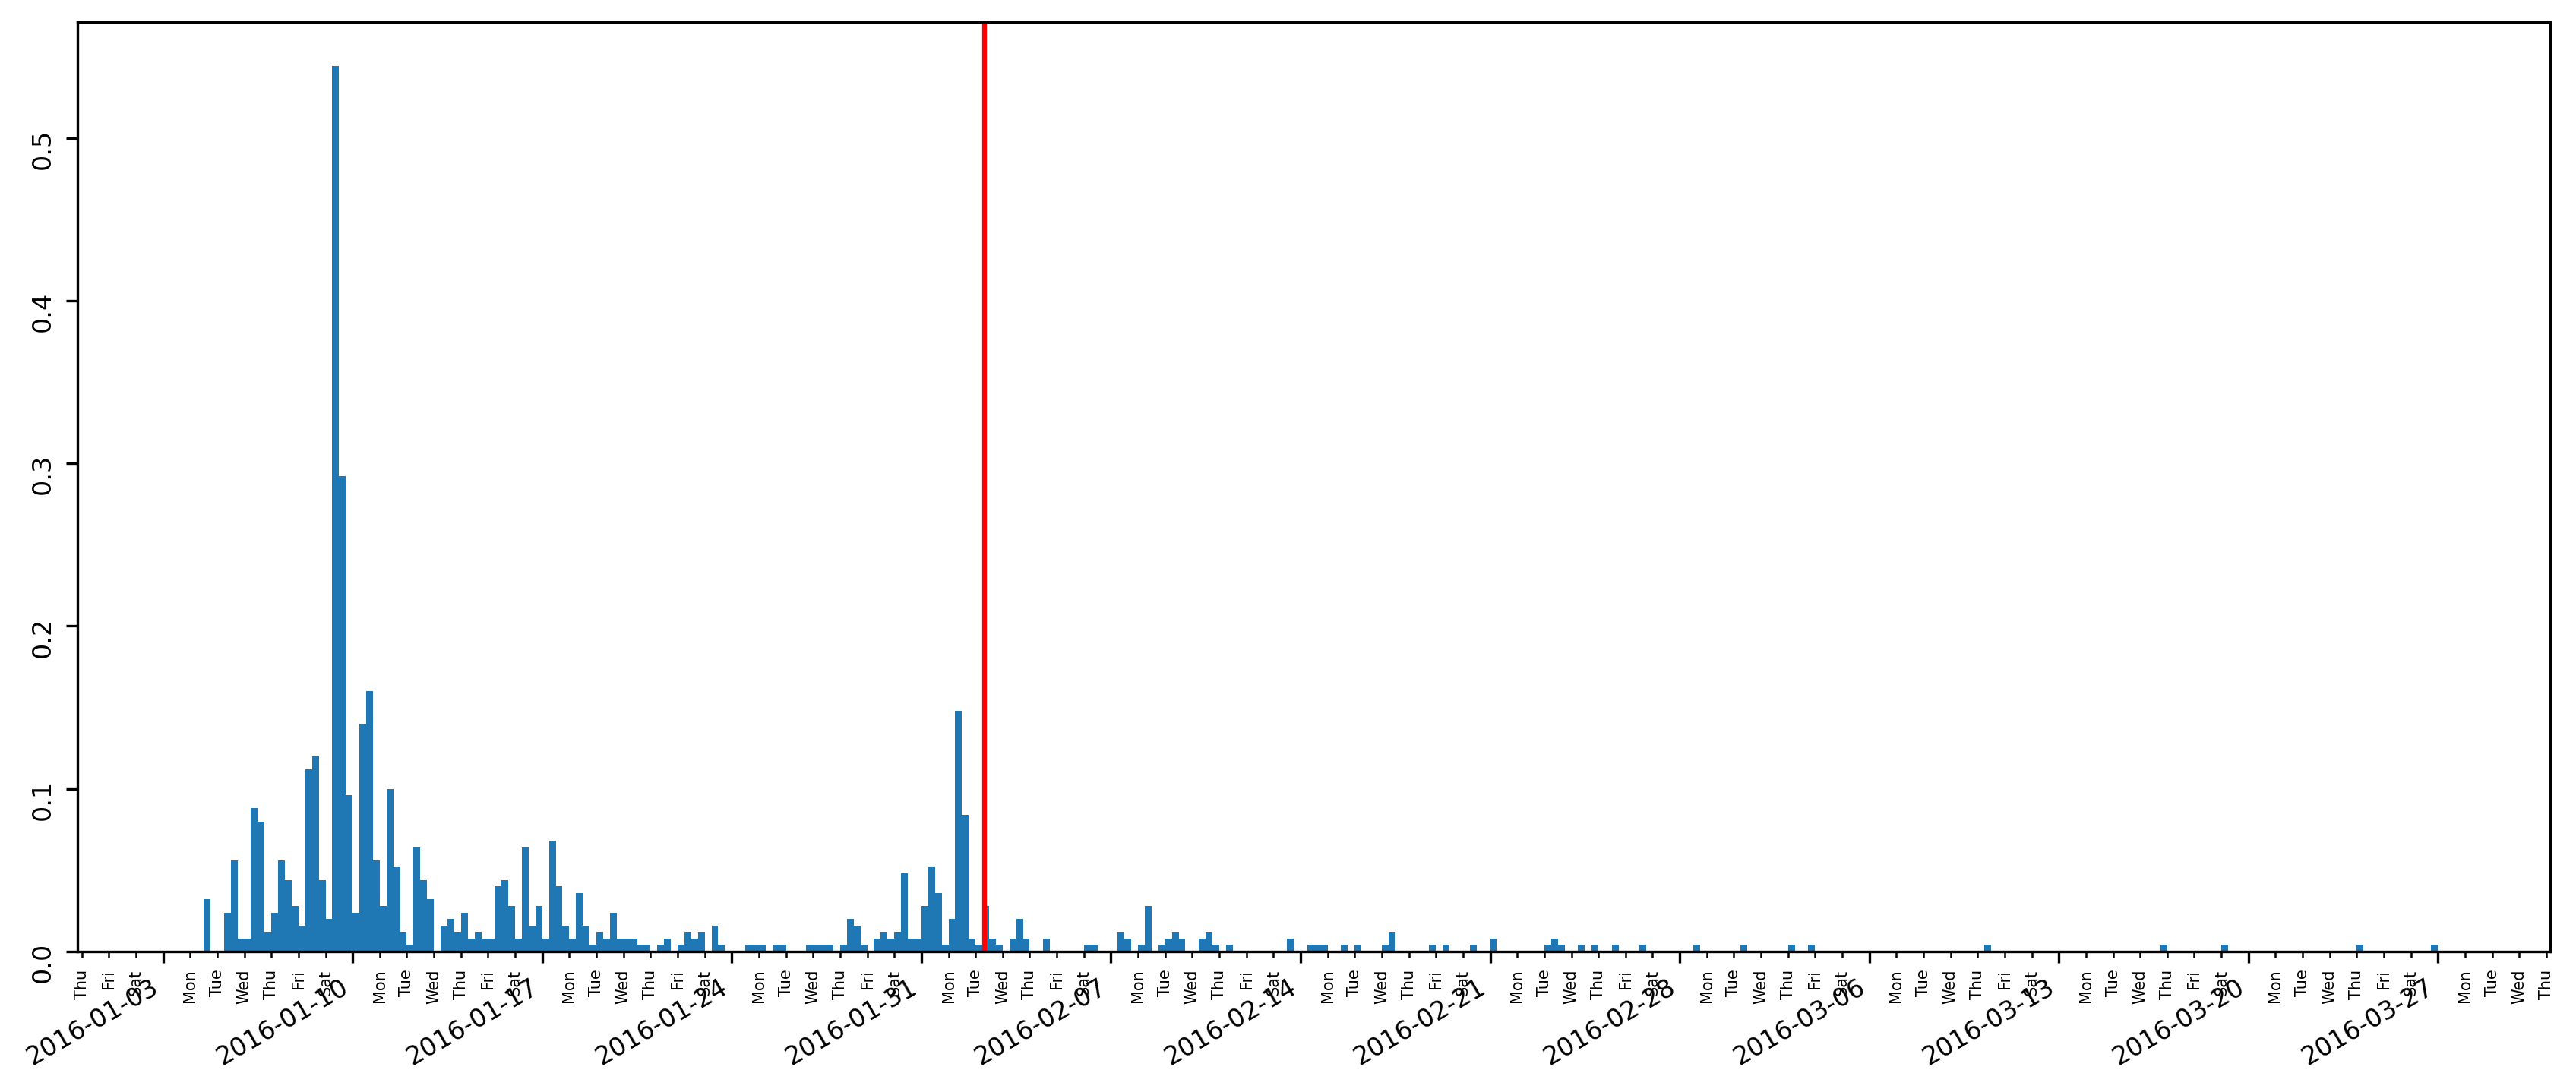

Application_828200680 [0.01718959] 0.0 2016-01-04 12:14:11.764627 2016-03-26 21:57:34.649150 82 days, 9:43:22.884523


/tmp/ipykernel_33874/2311270614.py:39: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.hist(case_samples, bins=pandas.date_range(start= pandas.to_datetime(min(case_samples)).floor('D'), end=pandas.to_datetime(max(case_samples)).ceil('D'), freq='6H'), density=True)


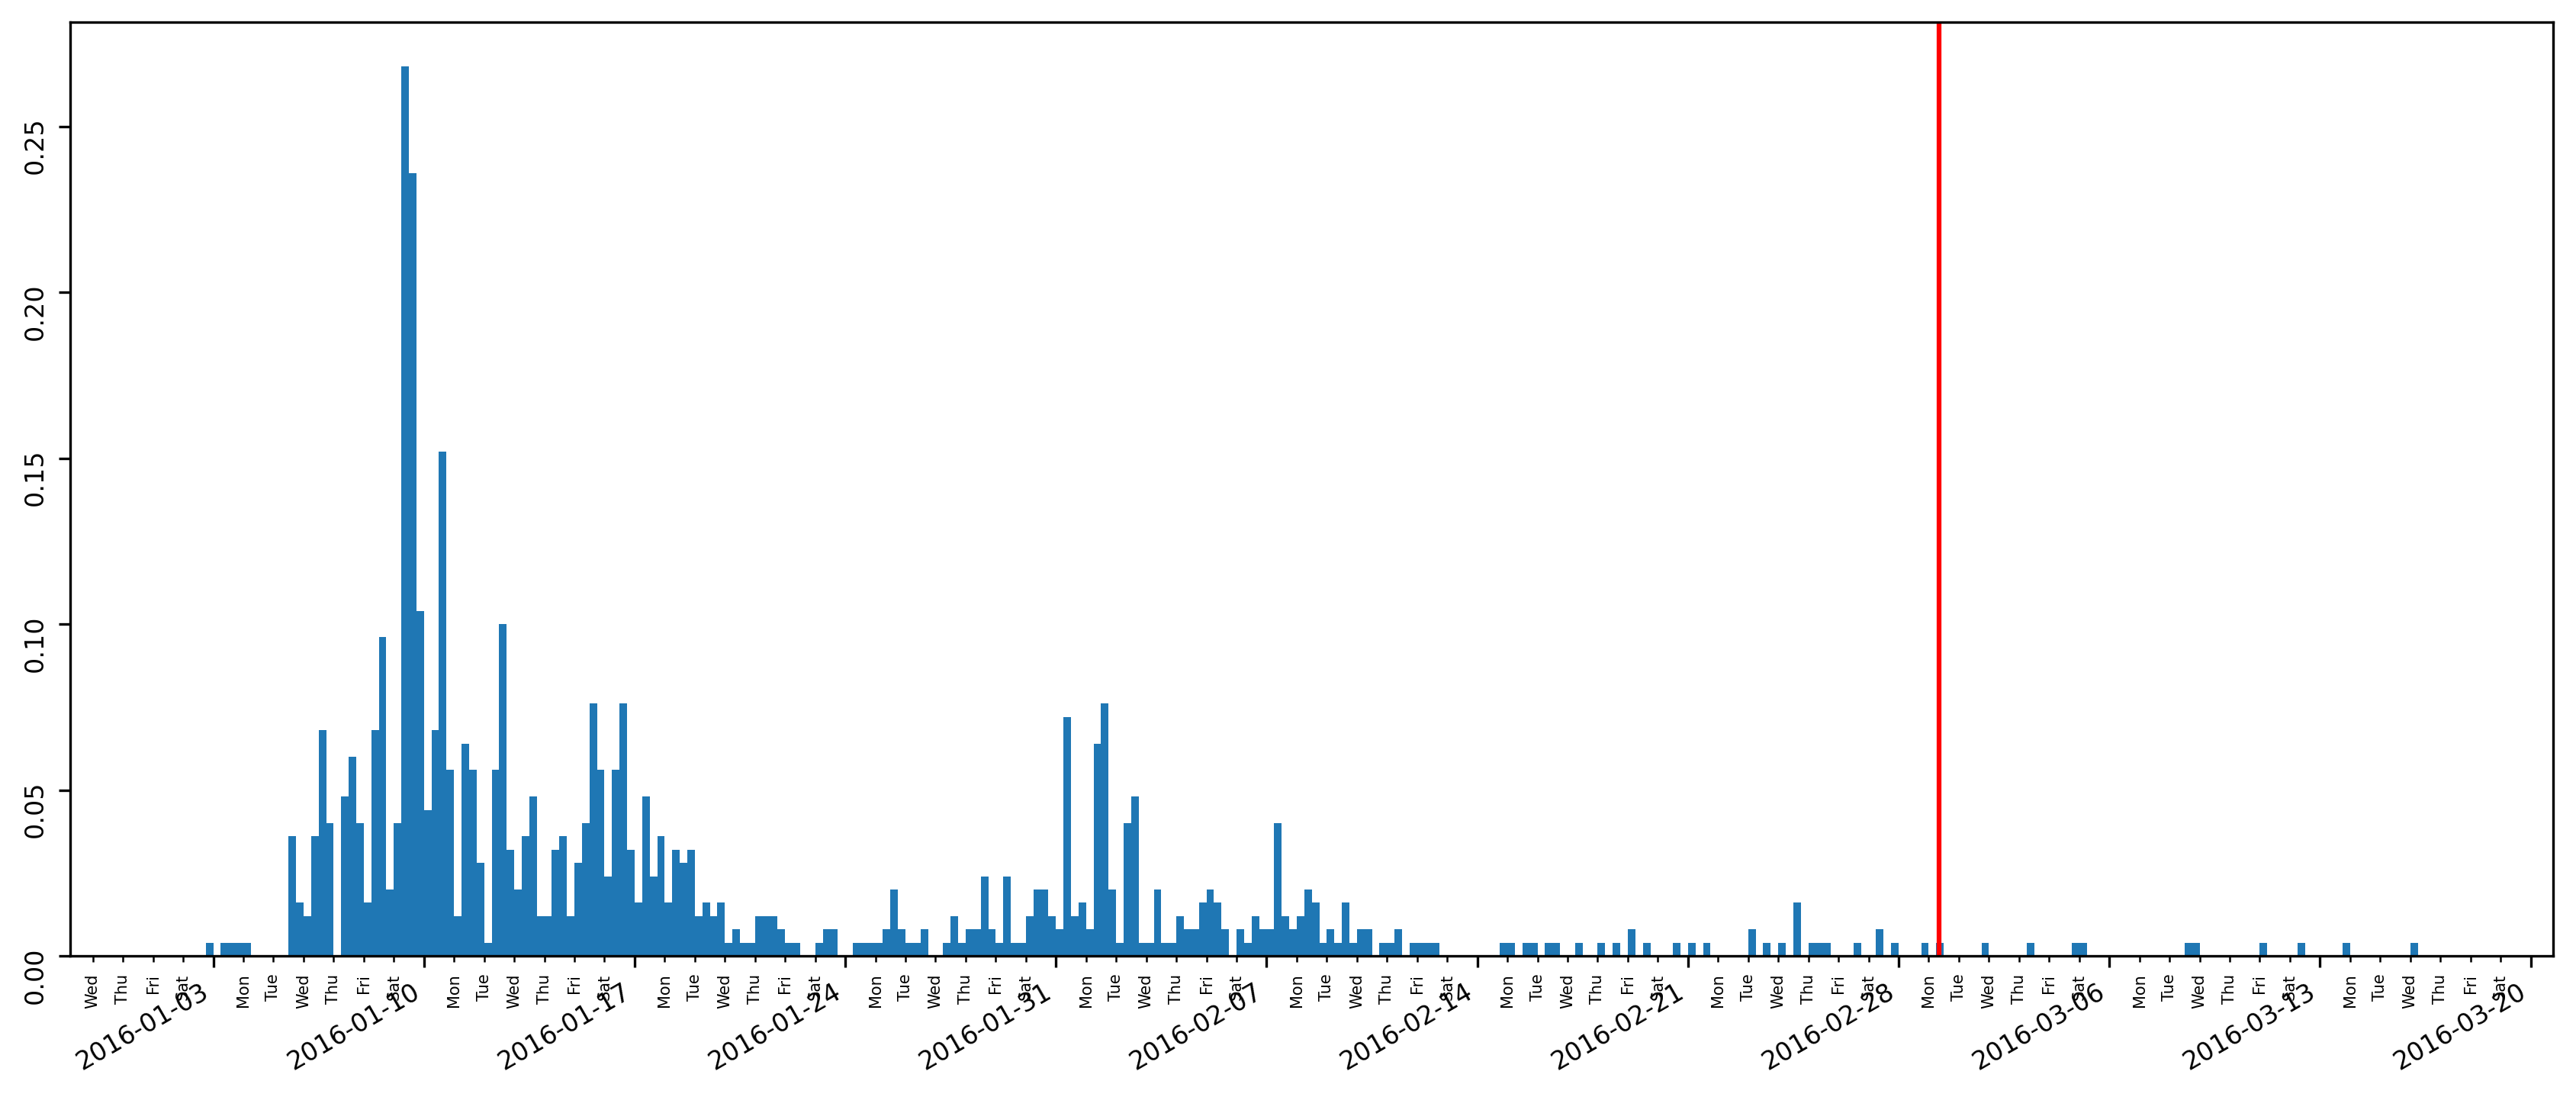

Application_1085880569 [0.00138606] 0.0 2016-01-02 18:44:14.186346 2016-03-16 00:42:29.834885 73 days, 5:58:15.648539


/tmp/ipykernel_33874/2311270614.py:39: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.hist(case_samples, bins=pandas.date_range(start= pandas.to_datetime(min(case_samples)).floor('D'), end=pandas.to_datetime(max(case_samples)).ceil('D'), freq='6H'), density=True)


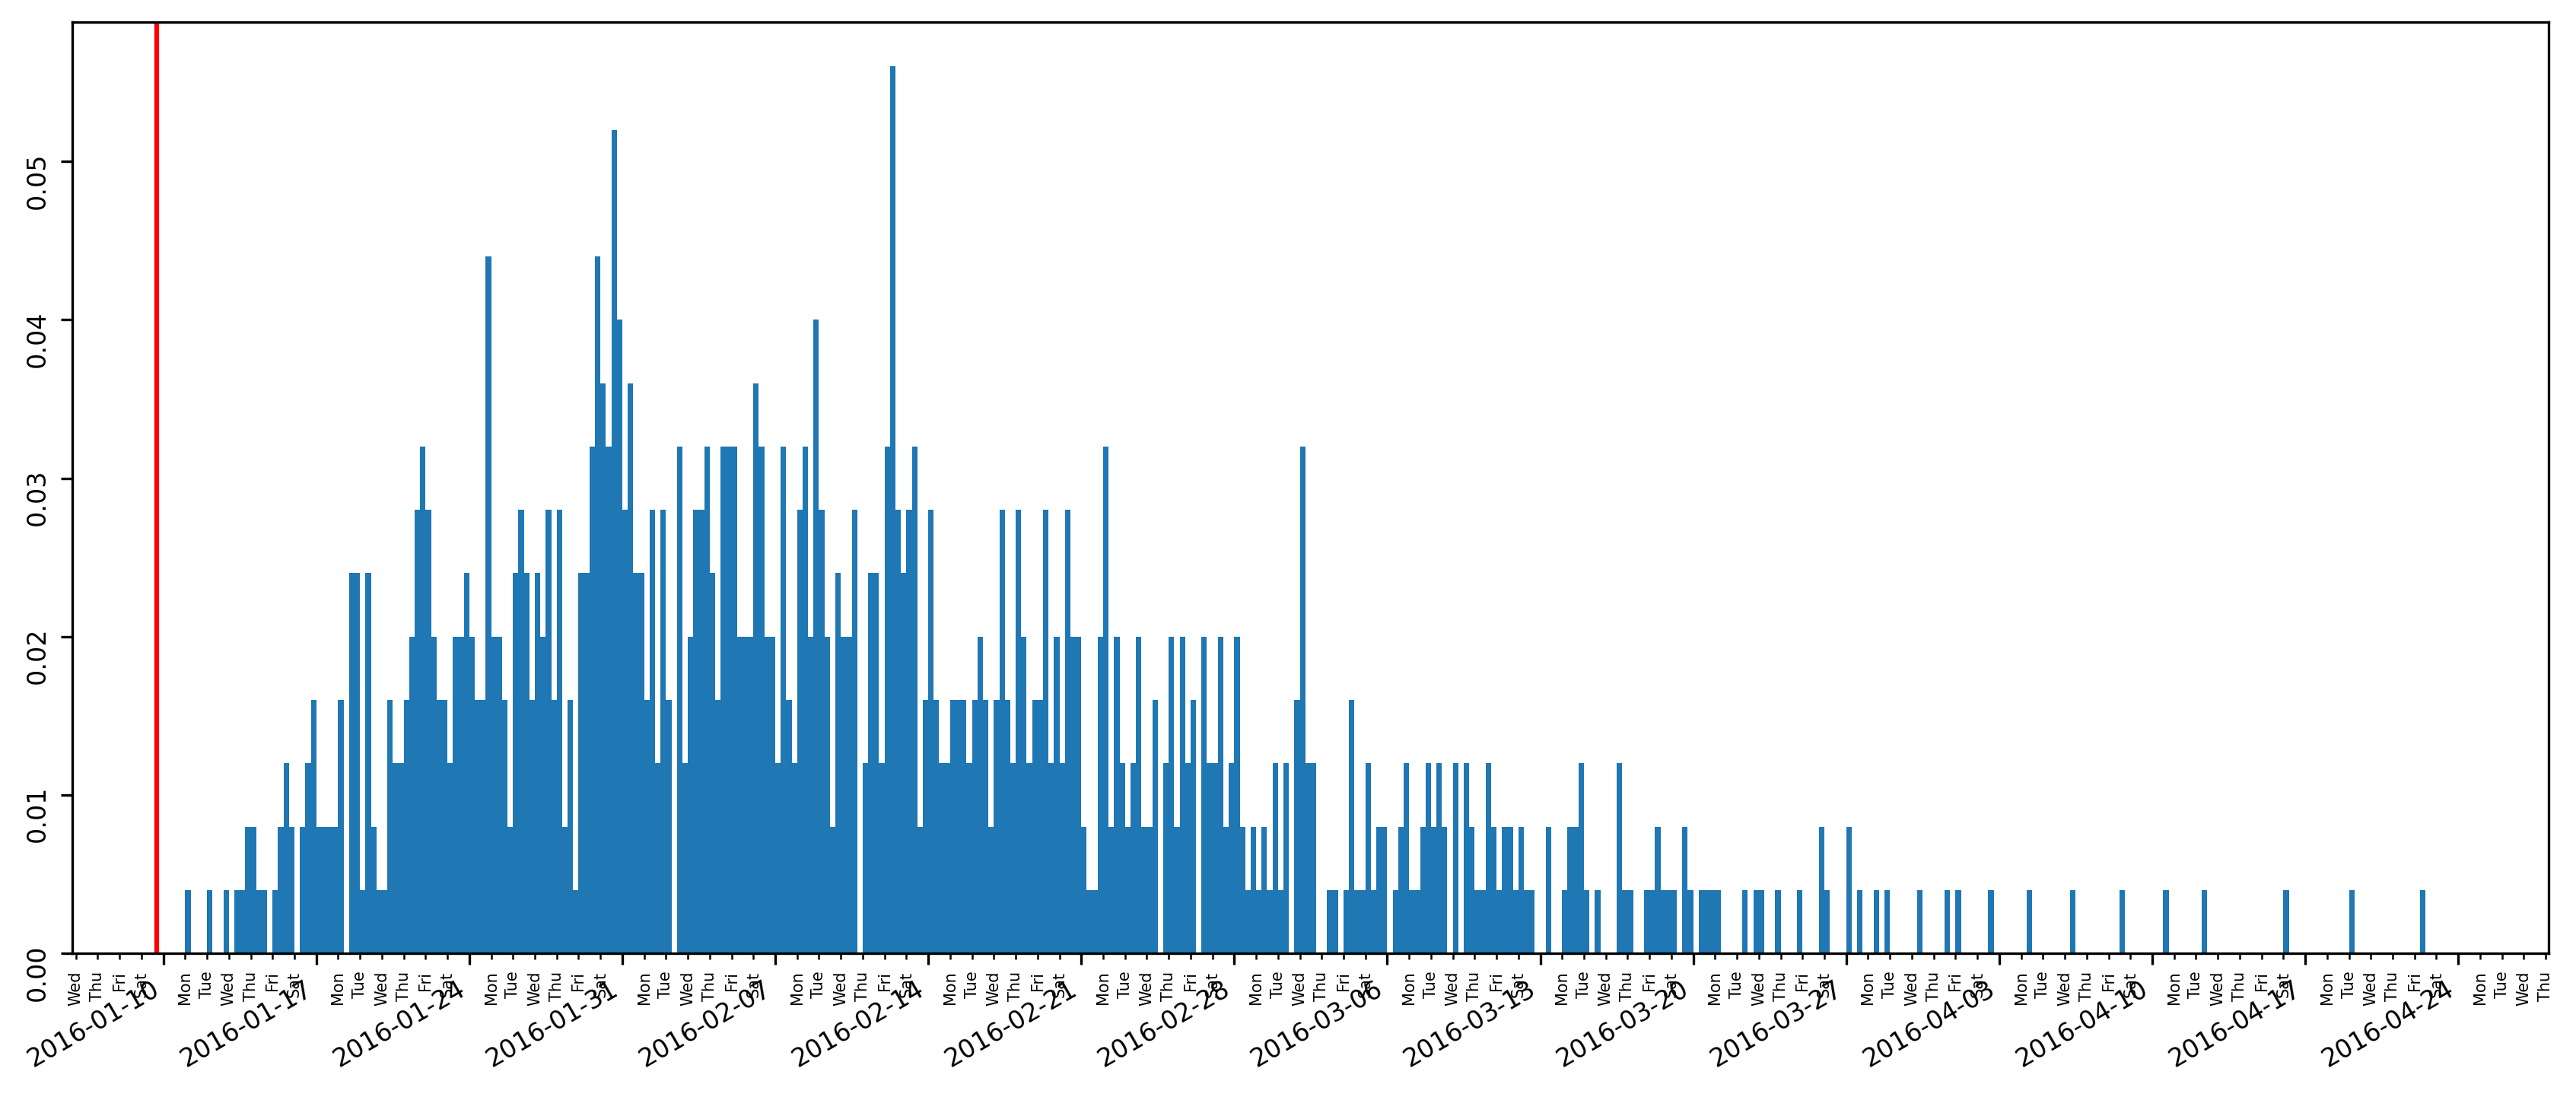

Application_1266995739 [0.0017494] 0.0 2016-01-11 05:58:31.690461 2016-04-22 09:23:16.869268 102 days, 3:24:45.178807


In [ ]:
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity

kde_likelihood = lambda samples, ground_truth : gaussian_kde(samples).pdf(ground_truth) * (3600*24)
kde_likelihood3 = lambda samples, ground_truth : np.exp(
                                                        KernelDensity(kernel='linear')\
                                                            .fit(np.expand_dims(np.array(samples), axis=1)).score([[ground_truth]])
                                                    ) * (3600*24)

get_real_end_time = lambda case_name : event_log[event_log['case:concept:name'] == case_name]['time:timestamp'].max().timestamp()

results = []
n = 10000
for case_name in event_log['case:concept:name'].unique():
    case_samples = [sample_drbart_bpic2017.sample_case(case_name) for i in range(n)]
    real_end_time = get_real_end_time(case_name)
    likelihood = kde_likelihood(case_samples, real_end_time)
    likelihood3 = kde_likelihood3(case_samples, real_end_time)

    
    case_samples = [datetime.datetime.fromtimestamp(ts) for ts in case_samples]
    real_end_time = datetime.datetime.fromtimestamp(real_end_time)

    plt.figure(figsize=(14, 6))
    #plt.xticks( rotation=25 )
    #print(case_samples)
    ax=plt.gca()
    xfmt = md.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(xfmt)
    ax.xaxis.set_major_locator(md.WeekdayLocator(byweekday=md.SU, interval=1))
    mxfmt = md.DateFormatter('%a')
    ax.xaxis.set_minor_formatter(mxfmt)
    ax.xaxis.set_minor_locator(md.DayLocator())
    ax.tick_params(axis='both', which='major', labelsize=8, rotation=90)
    ax.tick_params(axis='both', which='minor', labelsize=5, rotation=90)
    
    plt.gcf().autofmt_xdate()
    plt.gcf().set_dpi(300)
    plt.hist(case_samples, bins=pandas.date_range(start= pandas.to_datetime(min(case_samples)).floor('D'), end=pandas.to_datetime(max(case_samples)).ceil('D'), freq='6H'), density=True)
    plt.axvline(x=real_end_time, color='red')
    plt.show()
    results.append(likelihood[0])
    print(case_name, likelihood, likelihood3, min(case_samples), max(case_samples),  max(case_samples)-min(case_samples))


In [122]:
results

[0.042436447290008686,
 0.01968885627445208,
 0.03845577296450357,
 0.005822403515896293,
 0.02380137486695961,
 0.0013152585566427889,
 0.0007953706619390035,
 0.054205366061669424,
 0.02345478903263796,
 0.02132651741478251,
 0.024184055796751168,
 0.023261252271890003,
 0.027464235801649417,
 0.001602989032022994,
 0.006466346606491755,
 0.018982589294398205,
 0.03375347405250754,
 0.03318743642785096,
 0.022604448419879304,
 0.05105733117471643,
 0.00709334058070379,
 0.02442387521889594,
 0.028545785373842534,
 0.028545900724251776,
 0.07281819685932643,
 0.0010047226611544682,
 0.06382000095086185,
 0.0019889352043062905]

In [138]:
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity

kde_likelihood = lambda samples, ground_truth : gaussian_kde(samples).pdf(ground_truth) * (3600*24)
kde_likelihood3 = lambda samples, ground_truth : np.exp(
                                                        KernelDensity(kernel='linear')\
                                                            .fit(np.expand_dims(np.array(samples), axis=1)).score([[ground_truth]])
                                                    ) * (3600*24)

get_real_end_time = lambda case_name : event_log[event_log['case:concept:name'] == case_name]['time:timestamp'].max().timestamp()

n = 100
for case_name in event_log['case:concept:name'].unique():
    case_samples = [sample_drbart_bpic2017.sample_case(case_name) for i in range(n)]
    real_end_time = get_real_end_time(case_name)
    likelihood = kde_likelihood(case_samples, real_end_time)
    likelihood3 = kde_likelihood3(case_samples, real_end_time)

    
    case_samples = [datetime.datetime.fromtimestamp(ts) for ts in case_samples]
    real_end_time = datetime.datetime.fromtimestamp(real_end_time)

    plt.figure(figsize=(14, 6))
    #plt.xticks( rotation=25 )
    #print(case_samples)
    ax=plt.gca()
    xfmt = md.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(xfmt)
    ax.xaxis.set_major_locator(md.WeekdayLocator(byweekday=md.SU, interval=1))
    mxfmt = md.DateFormatter('%a')
    ax.xaxis.set_minor_formatter(mxfmt)
    ax.xaxis.set_minor_locator(md.DayLocator())
    ax.tick_params(axis='both', which='major', labelsize=8, rotation=90)
    ax.tick_params(axis='both', which='minor', labelsize=5, rotation=90)
    
    plt.gcf().autofmt_xdate()
    plt.gcf().set_dpi(300)
    plt.hist(case_samples, bins=pandas.date_range(start= pandas.to_datetime(min(case_samples)).floor('D'), end=pandas.to_datetime(max(case_samples)).ceil('D'), freq='6H'), density=True)
    plt.axvline(x=real_end_time, color='red')
    plt.show()
    print(case_name, likelihood, likelihood3, min(case_samples), max(case_samples),  max(case_samples)-min(case_samples))


TypeError: SampleOutcomes.sample_start_complete_time() takes 5 positional arguments but 7 were given

In [126]:
len(ll[:28])
np.median(ll[:28])

-3.74534625712711

In [127]:
np.mean(np.array(results[:28]))

0.0250752526103926